# Check dataflow

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
sys.path.insert(0, Path(".").absolute().parent.as_posix())

import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from common.dataset import FilesFromCsvDataset, TrainvalFilesDataset, TransformedDataset, read_image, TestFilesDataset

In [2]:
dataset = TrainvalFilesDataset("/home/storage_ext4_1tb/imaterialist-challenge-furniture-2018/train_400x400/")
img_dataset = TransformedDataset(dataset, transforms=lambda x: read_image(x), target_transforms=lambda y: y - 1)

In [3]:
from torchvision.transforms import Compose, RandomVerticalFlip, RandomHorizontalFlip, RandomCrop, CenterCrop
from torchvision.transforms import RandomApply, RandomAffine
from torchvision.transforms import ColorJitter, ToTensor, Normalize

basic_train_augs = Compose([
    RandomApply(
        [RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.7, 1.2), resample=2), ],
        p=0.5
    ),
    RandomCrop(size=350),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    ColorJitter(hue=0.1, brightness=0.1),
#     ToTensor(),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
img_augs_dataset = TransformedDataset(img_dataset, transforms=basic_train_augs)

In [19]:
from image_dataset_viz import render_datapoint, DatasetExporter

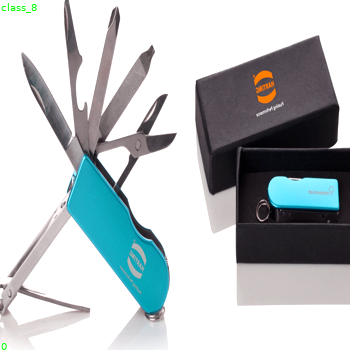

In [27]:
img, label = img_augs_dataset[0]
render_datapoint(img, "class_{}".format(label), image_id="0")

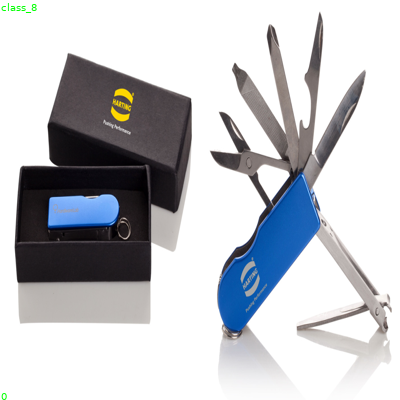

In [28]:
img, label = img_dataset[0]
render_datapoint(img, "class_{}".format(label), image_id="0")

Work with original size filtered dataset

In [29]:
dataset = FilesFromCsvDataset("../output/filtered_train_dataset.csv")
img_dataset = TransformedDataset(dataset, transforms=lambda x: read_image(x), target_transforms=lambda y: y - 1)

In [514]:
from torchvision.transforms import Compose, RandomVerticalFlip, RandomHorizontalFlip, RandomCrop, CenterCrop
from torchvision.transforms import RandomApply, RandomAffine, RandomResizedCrop, FiveCrop
from torchvision.transforms import ColorJitter, ToTensor, Normalize

basic_train_augs = Compose([
#     RandomApply(
#         [
    RandomResizedCrop(350, scale=(0.2, 1.0), interpolation=3),
#         ],
#         p=1.0
#     ),
#     CenterCrop(size=350),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(hue=0.1, brightness=0.1),
#     ToTensor(),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [515]:
img_augs_dataset = TransformedDataset(img_dataset, transforms=basic_train_augs)

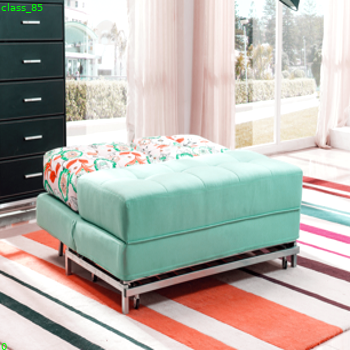

In [523]:
img, label = img_augs_dataset[190425]
render_datapoint(img, "class_{}".format(label), image_id="0")

A random subset on each epoch

In [4]:
dataset = FilesFromCsvDataset("../output/filtered_train_dataset.csv")

In [26]:
y = np.zeros((len(dataset, )), dtype=np.int)
for i, dp in enumerate(dataset):
    y[i] = dp[1] - 1

In [27]:
y.min(), y.max()

(0, 127)

In [28]:
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler

In [29]:
weights = np.ones((len(dataset), ))

In [47]:
lowest_recall_classes_weight = np.array([
    (3, 5.0),
    (14, 10.0),
    (18, 5.0),
    (26, 5.0),
    (38, 5.0),
    (49, 5.0),
    (62, 10.0),
    (65, 10.0),
    (104, 5.0),
    (123, 5.0)
])

for c, w in lowest_recall_classes_weight:
    indices = np.where(y == int(c))[0]
    weights[indices] = w

In [48]:
sampler = WeightedRandomSampler(weights, num_samples=25000)
sampler_indices = list(sampler)
len(sampler_indices), np.min(sampler_indices), np.max(sampler_indices)

(25000, 3, 191019)

In [51]:
np.bincount(y[sampler_indices])

array([ 101,  124,  236,  743,  130,   92,  148,  122,   34,  170,  169,
        244,  166,  175,  960,  128,  137,  144,  374,  387,  234,  133,
         97,  147,   43,  138,  989,  155,  112,  108,  196,  148,   90,
         54,   68,  159,  220,  220,  514,  179,   55,  364,  144,  117,
        199,  124,   82,  120,  149,  609,   83,   92,  109,  152,  193,
        164,   79,   74,  120,  154,  175,   68, 1601,  186,  109,  330,
        115,  183,  111,  132,  105,  112,  189,   53,  177,  227,   50,
        215,  176,  132,  152,  117,   23,  103,   57,   56,  137,  130,
        208,  123,  191,  243,  212,  116,  115,   94,   80,  157,  181,
        137,  199,  135,  195, 1798,  392,   77,  150,  150,   85,   74,
        167,  158,  130,   52,   80,  178,  213,  181,  116,  168,   40,
        237,  188,  190,  233,  179,   64,  122])

In [42]:
lowest_recall_classes_weight[:, 0]

array([  3.,  14.,  18.,  26.,  38.,  49.,  62.,  65., 104., 123.])

Work with random multi-image augs

In [4]:
from functools import partial
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip
from torchvision.transforms import RandomResizedCrop
from torchvision.transforms import ColorJitter, ToTensor, Normalize, Compose
from common.transforms import RandomMultiImageAugDataset, basic_random_half_blend

In [5]:
TRAIN_TRANSFORMS = [
    RandomResizedCrop(350, scale=(0.7, 1.0)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    ColorJitter(hue=0.1, brightness=0.2, contrast=0.2),
]

VAL_TRANSFORMS = [
    RandomResizedCrop(350, scale=(0.8, 1.0)),
    RandomHorizontalFlip(p=0.5),
]

common_transform = [
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]

In [24]:
n_classes = 128
dataset = FilesFromCsvDataset("../output/filtered_train_dataset.csv")
dataset = TransformedDataset(dataset, transforms=read_image, target_transforms=lambda l: l - 1)
dataset = TransformedDataset(dataset, transforms=Compose(TRAIN_TRANSFORMS))
dataset = RandomMultiImageAugDataset(dataset, n_classes, aug_fn=partial(basic_random_half_blend, alpha=0.3), p=1.0, min_n_images_per_class=2)

In [25]:
import random 

for i in range(200):
    index = random.randint(0, 12345)
    _ = dataset[index]

In [26]:
from image_dataset_viz import render_datapoint, DatasetExporter

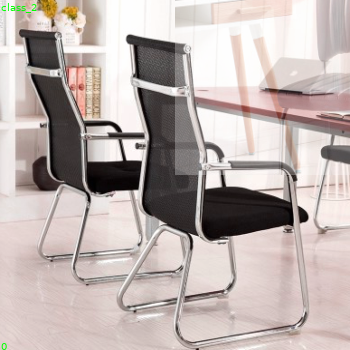

In [34]:
img, label = dataset[4222]
render_datapoint(img, "class_{}".format(label), image_id="0")

In [31]:
i = np.arange(128)[dataset.indices_per_label.sum(axis=1) > 3][0]
dataset.indices[dataset.indices_per_label[i, :]]

array([ 1761,  4020,  4222,  4255, 11052])

In [30]:
dataset.indices_per_label.sum(axis=1)

array([3, 0, 5, 4, 2, 1, 1, 1, 0, 2, 1, 3, 1, 3, 0, 0, 2, 5, 0, 5, 5, 0,
       1, 1, 0, 3, 3, 3, 1, 3, 2, 4, 0, 0, 1, 0, 3, 3, 0, 2, 0, 4, 2, 1,
       1, 2, 1, 0, 1, 0, 1, 1, 2, 2, 2, 2, 1, 3, 0, 2, 1, 0, 4, 2, 1, 0,
       1, 3, 0, 1, 1, 0, 2, 1, 1, 3, 0, 3, 2, 3, 1, 0, 0, 3, 1, 0, 1, 1,
       1, 1, 4, 4, 3, 1, 1, 1, 1, 2, 1, 3, 3, 2, 2, 3, 1, 1, 3, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 3, 0, 4, 0, 1, 3, 1, 3, 0, 2, 1])

In [2]:
from common.dataset import get_test_data_loader

dataset_path = Path("/home/storage_ext4_1tb/imaterialist-challenge-furniture-2018/")
test_dataset = TestFilesDataset(path=dataset_path / "val_400x400")